## 머신러닝을 활용한 아파트 거래금액 예측

### 전처리

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Apart Deal.csv')

In [30]:
data.head()

,지역코드,법정동,거래일,아파트,지번,전용면적,층,건축년도,거래금액
0,31110,학성동,5/30/2020 0:00,남운학성타운,379,135.5800,8,1991,26700
1,31110,남외동,1/3/2020 0:00,남외푸르지오1차,506-1,101.6000,2,2006,35500
2,31110,남외동,1/3/2020 0:00,에일린의뜰,500,84.9920,11,2007,36500
3,31110,남외동,1/3/2020 0:00,남외푸르지오1차,506-1,118.7060,8,2006,43000
4,31110,남외동,1/4/2020 0:00,남외푸르지오2차,501-1,84.9636,7,2007,38700


In [31]:
data.shape

(4315703, 9)

In [32]:
# '지역코드' 변수 타입 변환(int->str)
data['지역코드'] = data['지역코드'].astype(str)

In [33]:
# '층' 변수 타입 변환(object->float)
data['층'] =data['층'].replace(' ', "")
data['층'] = pd.to_numeric(data['층'])

In [34]:
# 거래일 date 형태 통일
data['거래일'] = pd.to_datetime(data['거래일'])
data['거래일'] = data['거래일'].astype(str)

# 년, 월, 일 변수 생성
data['년'] = data['거래일'].str.split('-').str[0]
data['월'] = data['거래일'].str.split('-').str[1]
data['일'] = data['거래일'].str.split('-').str[2]
data['일'] = data['일'].str.split(' ').str[0]

# 년, 월, 일 변수 type 변경
data[['년', '월']] = data[['년', '월']].astype('category')

In [35]:
data['일'] = data['일'].astype(np.int8)

In [36]:
data["일"] = data["일"].apply(lambda x: 'beginning' if x <=10 else 'middle' if x<=20 else 'end')

In [37]:
# 건축년도를 활용하여 연식 변수 생성
data['연식'] = 2022 - data['건축년도']

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4315703 entries, 0 to 4315702
Data columns (total 13 columns):
 #   Column  Dtype   
---  ------  -----   
 0   지역코드    object  
 1   법정동     object  
 2   거래일     object  
 3   아파트     object  
 4   지번      object  
 5   전용면적    float64 
 6   층       float64 
 7   건축년도    int64   
 8   거래금액    int64   
 9   년       category
 10  월       category
 11  일       object  
 12  연식      int64   
dtypes: category(2), float64(2), int64(3), object(6)
memory usage: 370.4+ MB


In [39]:
# 결측치 확인
data.isna().sum()

지역코드      0
법정동       0
거래일       0
아파트       0
지번      404
전용면적      0
층         1
건축년도      0
거래금액      0
년         0
월         0
일         0
연식        0
dtype: int64

In [40]:
# 분석에 사용하지 않을 변수 삭제
data_new = data.drop(columns=['지번', '거래일', '건축년도', '아파트', '법정동'])

In [41]:
# '층' 변수 결측치가 1개 존재하여 해당 행 삭제
data_new = data_new.dropna()
data_new.shape

(4315702, 8)

In [42]:
data_new.head()

,지역코드,전용면적,층,거래금액,년,월,일,연식
0,31110,135.5800,8.0,26700,2020,05,end,31
1,31110,101.6000,2.0,35500,2020,01,beginning,16
2,31110,84.9920,11.0,36500,2020,01,beginning,15
3,31110,118.7060,8.0,43000,2020,01,beginning,16
4,31110,84.9636,7.0,38700,2020,01,beginning,15


In [43]:
data_new[['층','연식']] = data_new[[ '층', '연식']].astype(np.int8)
data_new[['지역코드', '일']] = data_new[['지역코드', '일']].astype('category')

In [44]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4315702 entries, 0 to 4315702
Data columns (total 8 columns):
 #   Column  Dtype   
---  ------  -----   
 0   지역코드    category
 1   전용면적    float64 
 2   층       int8    
 3   거래금액    int64   
 4   년       category
 5   월       category
 6   일       category
 7   연식      int8    
dtypes: category(4), float64(1), int64(1), int8(2)
memory usage: 127.6 MB


In [45]:
data_new[['지역코드']] = data_new[['지역코드']].astype(int)

In [46]:
# 서울특별시만
data_new[data_new['지역코드']<20000]['지역코드'].unique()

array([11110, 11140, 11170, 11200, 11215, 11230, 11260, 11290, 11305,
       11320, 11350, 11380, 11410, 11440, 11470, 11500, 11530, 11545,
       11560, 11590, 11620, 11650, 11680, 11710, 11740])

In [47]:
data_new = data_new[data_new['지역코드']<20000]

In [48]:
data_new[['지역코드']] = data_new[['지역코드']].astype('category')

In [49]:
data_new[['년']] = data_new[['년']].astype('int64')
data_new2 = data_new[data_new['년']==2020]
data_new2.shape

(64357, 8)

In [50]:
data_new2.head()

,지역코드,전용면적,층,거래금액,년,월,일,연식
2144764,11110,73.39,5,57000,2020,01,beginning,3
2144765,11110,109.91,11,88000,2020,01,beginning,28
2144766,11110,194.43,4,130000,2020,01,beginning,18
2144767,11110,148.09,8,149000,2020,01,middle,19
2144768,11110,84.90,5,89800,2020,01,middle,27


In [51]:
data_new2.columns = ['region_code', 'size', 'level', 'price', 'year', 'month', 'day', 'age']
data_new2.head()

,region_code,size,level,price,year,month,day,age
2144764,11110,73.39,5,57000,2020,01,beginning,3
2144765,11110,109.91,11,88000,2020,01,beginning,28
2144766,11110,194.43,4,130000,2020,01,beginning,18
2144767,11110,148.09,8,149000,2020,01,middle,19
2144768,11110,84.90,5,89800,2020,01,middle,27


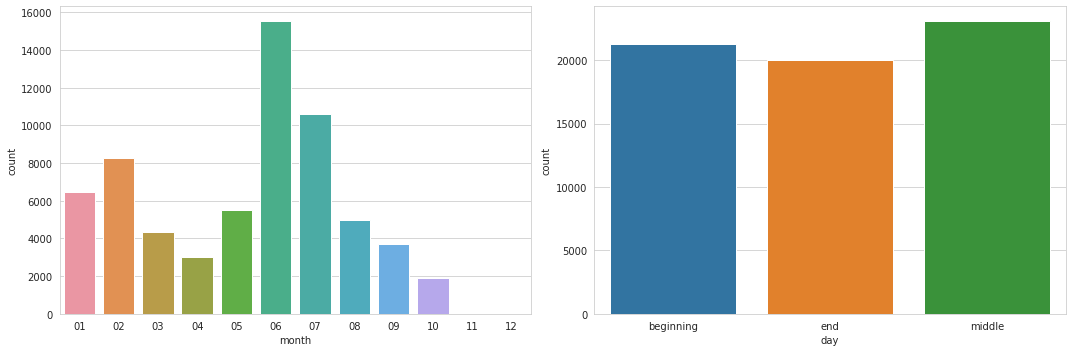

In [52]:
# 칼럼별 countplot
import seaborn as sns

plt.figure(figsize=(15,5))
for i, cat in enumerate(data_new2[['month', 'day']].columns):
    ax = plt.subplot(1,2,i+1)
    sns.set_style('whitegrid')
    sns.countplot(data = data_new2[['month', 'day']], x = cat, ax = ax)
    plt.tight_layout()
plt.show()

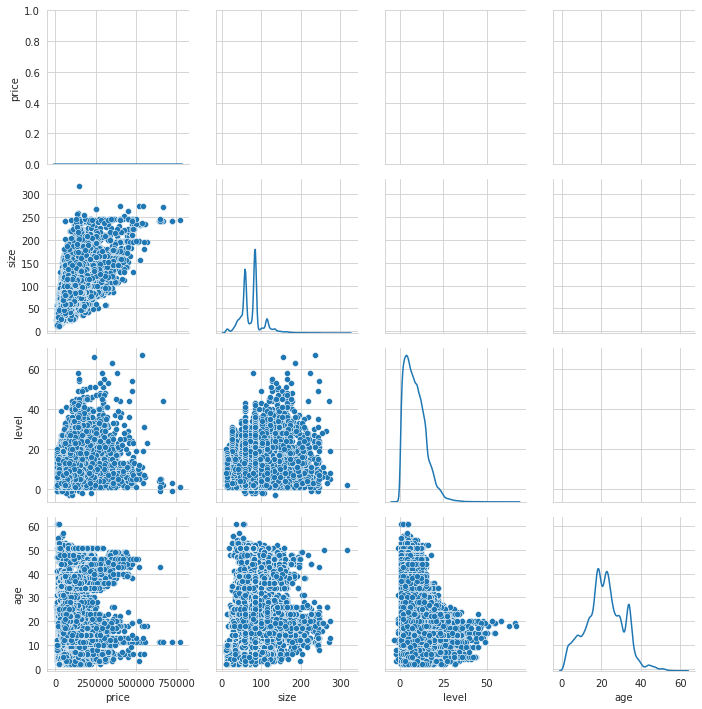

In [54]:
g = sns.PairGrid(data_new2[['price', 'size', 'level', 'age']]) 
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
plt.show()

In [55]:
data_final = pd.get_dummies(data_new2)

In [56]:
data_final = data_final.drop(columns=['year'], axis=1)

data_final = data_final.reset_index()
data_final = data_final.drop(columns='index', axis=1)
data_final.head()

,size,level,price,age,region_code_11110,region_code_11140,region_code_11170,region_code_11200,region_code_11215,region_code_11230,region_code_11260,region_code_11290,region_code_11305,region_code_11320,region_code_11350,region_code_11380,region_code_11410,region_code_11440,region_code_11470,region_code_11500,region_code_11530,region_code_11545,region_code_11560,region_code_11590,region_code_11620,region_code_11650,region_code_11680,region_code_11710,region_code_11740,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,day_beginning,day_end,day_middle
0,73.39,5,57000,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,109.91,11,88000,28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,194.43,4,130000,18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,148.09,8,149000,19,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,84.90,5,89800,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [57]:
data_final.shape

(64357, 44)

### train/test split

In [58]:
y = data_final['price']
X = data_final.drop('price',axis=1, inplace=False)

In [59]:
X.shape

(64357, 43)

#### 반응변수 분포 확인

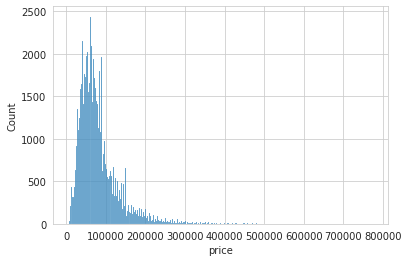

In [60]:
import seaborn as sns
sns.histplot(y)   # y의 분포 확인

In [61]:
log_y = np.log1p(y)

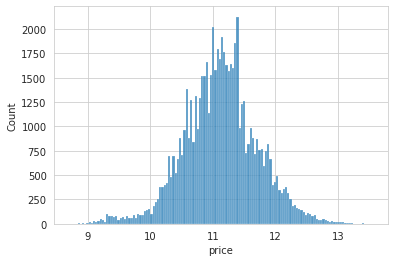

In [62]:
sns.histplot(log_y)   # log y의 분포 확인

#### 설명변수 스케일링

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X.iloc[:,:4])

In [64]:
X_scaled_num = pd.DataFrame(X_scaled)

In [65]:
X['size'] = X_scaled_num.iloc[:,0]
X['level'] = X_scaled_num.iloc[:,1]
X['age'] = X_scaled_num.iloc[:,2]

In [67]:
X.head()

,size,level,age,region_code_11110,region_code_11140,region_code_11170,region_code_11200,region_code_11215,region_code_11230,region_code_11260,region_code_11290,region_code_11305,region_code_11320,region_code_11350,region_code_11380,region_code_11410,region_code_11440,region_code_11470,region_code_11500,region_code_11530,region_code_11545,region_code_11560,region_code_11590,region_code_11620,region_code_11650,region_code_11680,region_code_11710,region_code_11740,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,day_beginning,day_end,day_middle
0,-0.096659,-0.665309,-1.979605,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1.166636,0.333687,0.678552,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,4.090340,-0.831809,-0.384711,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2.487353,-0.165811,-0.278384,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.301494,-0.665309,0.572226,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


#### split

In [66]:
# training set 80%, test set 20%
X_train, X_test, y_train, y_test = train_test_split(X, log_y, test_size=0.2, random_state=2021)

### 모델링

#### 기본 모델 학습

In [ ]:
rf_reg = RandomForestRegressor(n_estimators = 100, random_state = 2021)
et_reg = ExtraTreesRegressor(n_estimators=100, random_state=2021)
df_reg = DecisionTreeRegressor(random_state = 2021)
svm_lin_reg = LinearSVR( random_state = 2021)
svm_ploy2_reg = SVR(kernel='poly', degree=2)
svm_ploy3_reg = SVR(kernel='poly', degree=3)
lr_reg = LinearRegression()
gb_reg = GradientBoostingRegressor(n_estimators = 100, random_state = 2021)
ada_reg = AdaBoostRegressor(n_estimators=100, random_state=2021)
xgb_reg = XGBRegressor(n_estimators=100, random_state=2021)
lgbm_reg = LGBMRegressor(n_estimators=100, random_state=2021)

In [72]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [75]:
# rmse 계산하는 함수
def get_rmse(y_test,pred):
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('RMSE: {0:.3f}'.format(rmse))

In [76]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    get_rmse(y_test, pred)

In [ ]:
for model in [lr_reg, rf_reg, et_reg, df_reg, svm_lin_reg, gb_reg, ada_reg, xgb_reg, lgbm_reg]:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSE: 36841.998
### RandomForestRegressor ###
RMSE: 14358.271
### ExtraTreesRegressor ###
RMSE: 15662.138
### DecisionTreeRegressor ###
RMSE: 18917.984
### LinearSVR ###
RMSE: 33892.254
### GradientBoostingRegressor ###
RMSE: 25369.337
### AdaBoostRegressor ###
RMSE: 36990.413
[05:19:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSE: 25472.543
### LGBMRegressor ###
RMSE: 19714.219


In [ ]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(random_state=2021)

for model in [sgd_reg, svm_ploy2_reg, svm_ploy3_reg]:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### SGDRegressor ###
RMSE: 35719.254
### SVR ###
RMSE: 28520.084
### SVR ###
RMSE: 9906679.175


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

ridge_reg = Ridge(alpha=10, solver="cholesky", random_state=2021)
lasso_reg = Lasso(alpha=0.01, random_state=2021)
elastic_net = ElasticNet(alpha=0.01, random_state=2021)

In [ ]:
for model in [ridge_reg, lasso_reg, elastic_net]:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### Ridge ###
RMSE: 36819.863
### Lasso ###
RMSE: 39788.968
### ElasticNet ###
RMSE: 37969.825


tree 기반 모델 과적합 가능성 존재 -> 하이퍼파라미터 튜닝 필요

하이퍼파라미터 튜닝 전 성능이 상대적으로 좋았던 모델들에 대해서 하이퍼파라미터 튜닝을 통해 과적합 방지 및 성능 개선을 시도함

#### 하이퍼파라미터 튜닝

##### RandomForestRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV
rf_clf_0 =  RandomForestRegressor(random_state = 2021)

param_grid = [
    {'max_depth':[4, 5, 6, 7], 
    'min_samples_split':[3, 4, 5],
    'max_leaf_nodes':[8, 9, 10],
    'n_estimators': [10, 100, 200]}
]

result = GridSearchCV(rf_clf_0, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 5)
result.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=2021),
             param_grid=[{'max_depth': [4, 5, 6, 7],
                          'max_leaf_nodes': [8, 9, 10],
                          'min_samples_split': [3, 4, 5],
                          'n_estimators': [10, 100, 200]}],
             scoring='neg_mean_squared_error')

In [ ]:
result.best_params_

{'max_depth': 7,
 'max_leaf_nodes': 10,
 'min_samples_split': 3,
 'n_estimators': 100}

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
rf_clf_2 =  RandomForestRegressor(max_depth = 7 ,max_leaf_nodes = 10, min_samples_split = 3, 
                                  n_estimators=100, random_state = 2021)

get_model_predict(rf_clf_2, X_train, X_test, y_train, y_test, is_expm1=True)

### RandomForestRegressor ###
RMSE: 38829.296


파라미터 조정을 했더니 rmse가 매우 커짐. 이전 기본 모델의 과적합되었다는 것을 확인할 수 있음.

##### GradientBoostingRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV
gb_reg_0 = GradientBoostingRegressor( random_state = 2021)

param_grid = [
    {'max_depth':[5, 6, 7], 
    'min_samples_split':[3, 4, 5],
    'learning_rate':[0.01, 0.1],
    'n_estimators': [10, 100, 200]}
]

result1 = GridSearchCV(gb_reg_0, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 5)
result1.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=2021),
             param_grid=[{'learning_rate': [0.01, 0.1], 'max_depth': [5, 6, 7],
                          'min_samples_split': [3, 4, 5],
                          'n_estimators': [10, 100, 200]}],
             scoring='neg_mean_squared_error')

In [ ]:
result1.best_params_

{'learning_rate': 0.1,
 'max_depth': 7,
 'min_samples_split': 5,
 'n_estimators': 200}

In [ ]:
gb_reg_2 =  GradientBoostingRegressor(max_depth = 7 ,learning_rate = 0.1, min_samples_split = 5, 
                                  n_estimators=200, random_state = 2021)

get_model_predict(gb_reg_2, X_train, X_test, y_train, y_test, is_expm1=True)

### GradientBoostingRegressor ###
RMSE: 16374.592


기본모델: RMSE: 25369.337  -> 튜닝 후: 16374.59로 감소하였다.

##### XGBRegressor

In [ ]:
xgb_reg_0 = XGBRegressor(random_state=2021, objective='reg:squarederror')

param_grid = [
    {'max_depth':[5, 6, 7], 
    'alpha':[0.1, 1, 10],
    'learning_rate':[0.01, 0.1],
    'n_estimators': [10, 100, 200]}
]

result2 = GridSearchCV(xgb_reg_0, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 5)
result2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(objective='reg:squarederror',
                                    random_state=2021),
             param_grid=[{'alpha': [0.1, 1, 10], 'learning_rate': [0.01, 0.1],
                          'max_depth': [5, 6, 7],
                          'n_estimators': [10, 100, 200]}],
             scoring='neg_mean_squared_error')

In [ ]:
result2.best_params_

{'alpha': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

In [ ]:
xgb_reg_2 =  XGBRegressor(max_depth = 7 ,learning_rate = 0.1, alpha=0.1,
                                  n_estimators=200, random_state = 2021, objective='reg:squarederror')

get_model_predict(xgb_reg_2, X_train, X_test, y_train, y_test, is_expm1=True)

### XGBRegressor ###
RMSE: 16786.485


기본모델: RMSE: 25472.543 -> 튜닝 후: RMSE: 16786.485로 감소하였다.

##### SVR

In [ ]:
from sklearn.model_selection import GridSearchCV
svm_ploy2_reg_0 = SVR(kernel='poly', degree=2)

param_grid = [
    {'C': [0.1], 
     'gamma': [0.1,0.01]}
]

result3 = GridSearchCV(svm_ploy2_reg_0, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 5)
result3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(degree=2, kernel='poly'),
             param_grid=[{'C': [0.1], 'gamma': [0.1, 0.01]}],
             scoring='neg_mean_squared_error')

In [ ]:
result3.best_params_

{'C': 0.1, 'gamma': 0.1}

In [ ]:
svm_ploy2_reg_1 = SVR(kernel='poly', degree=2, C=0.1, gamma=0.1)

get_model_predict(svm_ploy2_reg_1, X_train, X_test, y_train, y_test, is_expm1=True)

### SVR ###
RMSE: 28539.451


In [ ]:
svm_ploy2_reg_0 = SVR(kernel='poly', degree=2)

param_grid = [
    {'C': [1], 
     'gamma': [0.1,0.01]}
]

result3_2 = GridSearchCV(svm_ploy2_reg_0, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 5)
result3_2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(degree=2, kernel='poly'),
             param_grid=[{'C': [1], 'gamma': [0.1, 0.01]}],
             scoring='neg_mean_squared_error')

In [ ]:
result3_2.best_params_

{'C': 1, 'gamma': 0.1}

In [ ]:
svm_ploy2_reg_2 = SVR(kernel='poly', degree=2, C=1, gamma=0.1)

get_model_predict(svm_ploy2_reg_2, X_train, X_test, y_train, y_test, is_expm1=True)

### SVR ###
RMSE: 28496.724


#### 앙상블

In [68]:
gb_reg_2 =  GradientBoostingRegressor(max_depth = 7 ,learning_rate = 0.1, min_samples_split = 5, 
                                  n_estimators=200, random_state = 2021)

In [69]:
xgb_reg_2 =  XGBRegressor(max_depth = 7 ,learning_rate = 0.1, alpha=0.1,
                                  n_estimators=200, random_state = 2021, objective='reg:squarederror')

In [88]:
from sklearn.ensemble import VotingRegressor

voting_clf = VotingRegressor(
 estimators=[('gbr', gb_reg_2), ('xgb', xgb_reg_2)])

cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_score = cross_val_score(voting_clf, X, y, cv=cv, scoring='neg_mean_squared_error')

print(((-cv_score)**(0.5)).mean())

16010.881264509517

### 최종 모델 선택
GradientBoostRegressor와 XGBRegressor가 Voting 앙상블된 모델